<a href="https://colab.research.google.com/github/amrmoohamed/RLinTrading/blob/main/GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Installation & Importing**

In [ ]:
# Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!git clone https://github.com/AI4Finance-LLC/FinRL-Library.git
!pip install -r /content/FinRL-Library/requirements.txt

In [ ]:
!wget https://github.com/AI4Finance-LLC/FinRL-Library/files/5879628/env.zip

!unzip /content/env.zip

!cp /content/env/EnvMultipleStock_trade.py /usr/local/lib/python3.7/dist-packages/finrl/env
!cp /content/env/EnvMultipleStock_train.py /usr/local/lib/python3.7/dist-packages/finrl/env
!cp /content/env/environment.py /usr/local/lib/python3.7/dist-packages/finrl/env

In [ ]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4

In [ ]:
!pip install yahoo_fin
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv
#from finrl.env.env_stocktrading import StockTradingEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats,get_baseline,trx_plot 

import sys
sys.path.append("../FinRL-Library")

from yahoo_fin import stock_info as si
from yahoo_fin.stock_info import get_data

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

#**Data preparaing**

##**Day Gainers-Losers-Active stocks**

In [ ]:
gainers = si.get_day_gainers()
tengainers = gainers[:10]
tengainerssymbols = list(gainers[:10]['Symbol'])
losers = si.get_day_losers()
tenlosers = losers[:10]
tenloserssymbols = list(losers[:10]['Symbol'])
actives = si.get_day_most_active()
tenactives = actives[:10]
tenactivesymbols = list(actives[:10]['Symbol'])

In [ ]:
yeartoday = 365
years = 6
start_date = datetime.datetime.now() - datetime.timedelta(days= years*yeartoday)
start_date = str(start_date)[:10]
end_date = datetime.date.today()
end_date = str(end_date)

In [ ]:
tickers = tengainerssymbols.copy()
tickers.extend(tenloserssymbols)
tickers.extend(tenactivesymbols)

In [ ]:
print(tickers)

['TGLVY', 'NOVN', 'RLLCF', 'MDLA', 'SAVA', 'AMC', 'ZH', 'JKS', 'DRNA', 'TIGR', 'UPST', 'RAMP', 'VRTX', 'LTCN', 'GOTU', 'CRCT', 'CVAC', 'WISH', 'BACHF', 'SANA', 'AMC', 'CLOV', 'NOVN', 'WISH', 'NIO', 'RLLCF', 'CLF', 'BB', 'AAPL', 'F']


##**stocks with enough historical data**

In [ ]:
for t in tickers:
  df = get_data(t,start_date,end_date,index_as_date = True, interval="1d")
  df.dropna(axis=0,inplace=True)
  df.to_csv(f'{t}.csv')

In [ ]:
df_A = get_data('AAPL',start_date,end_date, interval="1d")
biggestdf = df_A.shape[0]

In [ ]:
for t in tickers:
  data = pd.read_csv(f'{t}.csv', index_col=0)
  datasize = data.shape[0]
  if datasize != biggestdf:
    tickers.remove(t)
  else:
    pass
    #tenactivesymbolls = tenactivesymbols

In [ ]:
#tickers.remove('F')

In [ ]:
print(tickers)

['TGLVY', 'SAVA', 'AMC', 'JKS', 'DRNA', 'RAMP', 'VRTX', 'BACHF', 'AMC', 'CLF', 'BB', 'AAPL', 'F']


In [ ]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (19617, 8)


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(18108, 8)

#**Feautre pipeline**

In [ ]:
#tech_indicator_list=config.TECHNICAL_INDICATORS_LIST
## you can add more technical indicators
## visit https://github.com/jealous/stockstats for different names

tech_indicator_list=config.TECHNICAL_INDICATORS_LIST

In [ ]:
tech_indicator_list.remove('cci_30')

In [ ]:
print(tech_indicator_list)

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'dx_30', 'close_30_sma', 'close_60_sma']


In [ ]:
tech_indicator_list = tech_indicator_list +['dma','trix','open_30_sma','open_60_sma']

In [ ]:
print(tech_indicator_list)

['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'dma', 'trix', 'open_30_sma', 'open_60_sma']


In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=True,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
df.shape

(18108, 20)

In [ ]:
df.head()

date     open       high  ...  open_30_sma  open_60_sma  turbulence
0  2015-06-16  31.7575  31.962500  ...      31.7575      31.7575         0.0
1  2015-06-16  28.8500  28.879999  ...      28.8500      28.8500         0.0
2  2015-06-16   0.6700   0.670000  ...       0.6700       0.6700         0.0
3  2015-06-16   9.3500   9.460000  ...       9.3500       9.3500         0.0
4  2015-06-16   5.3700   5.400000  ...       5.3700       5.3700         0.0

[5 rows x 20 columns]

##**Add covariance matrix as states**

In [ ]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [ ]:
df.shape

(15084, 21)

In [ ]:
df.describe()

open          high  ...   open_60_sma    turbulence
count  15084.000000  15084.000000  ...  15084.000000  15084.000000
mean      30.815526     31.331893  ...     30.141895     18.117651
std       50.667146     51.337188  ...     49.743467     55.037941
min        0.300000      0.310000  ...      0.334167      0.000000
25%        5.320000      5.450037  ...      5.254500      5.219002
50%       11.395000     11.610000  ...     11.233583      8.859655
75%       28.313125     28.723750  ...     27.561167     15.389020
max      300.649994    306.079987  ...    283.603832   1377.232656

[8 rows x 18 columns]

In [ ]:
df.head()

date  ...                                           cov_list
0  2016-06-15  ...  [[0.00031302681397030093, 0.000116429088488086...
1  2016-06-15  ...  [[0.00031302681397030093, 0.000116429088488086...
2  2016-06-15  ...  [[0.00031302681397030093, 0.000116429088488086...
3  2016-06-15  ...  [[0.00031302681397030093, 0.000116429088488086...
4  2016-06-15  ...  [[0.00031302681397030093, 0.000116429088488086...

[5 rows x 21 columns]

#**Design Environment**

##**Class**

In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

#**ENV**

In [ ]:
#when add Covariance Matrix
trainsize = 0.75

start_date_after_cov = pd.to_datetime(start_date) + datetime.timedelta(days=365)
start_train = str(start_date_after_cov)[:10]

Interval = pd.to_datetime(end_date) - pd.to_datetime(start_date_after_cov)
train_Interval = trainsize * Interval

end_train = start_date_after_cov + datetime.timedelta(days= train_Interval.days)
end_train = str(end_train)[:10]
end_trade = pd.to_datetime(end_date)
end_trade = str(end_trade)[:10]

#start_train = str(start_date)[:10]

In [ ]:
#when not add Covariance Matrix

trainsize = 0.9

start_train = str(start_date)[:10]

Interval = pd.to_datetime(end_date) - pd.to_datetime(start_date)
train_Interval = trainsize * Interval

end_train = pd.to_datetime(start_date) + datetime.timedelta(days= train_Interval.days)
end_train = str(end_train)[:10]
end_trade = pd.to_datetime(end_date)
end_trade = str(end_trade)[:10]

In [ ]:
train = data_split(df, start = start_train, end = end_train)
trade = data_split(df, start = end_train, end = end_trade)

In [ ]:
train.head(2)

date  ...                                           cov_list
0  2016-06-15  ...  [[0.00031302681397030093, 0.000116429088488086...
0  2016-06-15  ...  [[0.00031302681397030093, 0.000116429088488086...

[2 rows x 21 columns]

##**Environment for Portfolio Allocation**

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
#state_space = 1 + 2*stock_dimension + len(tech_indicator_list)*stock_dimension
#state_space = 1 + 2*(stock_dimension+2) + (len(tech_indicator_list)-2)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 12, State Space: 12


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000,
    "transaction_cost_pct": 0.001, 
    #"buy_cost_pct": 0.001,
    #"sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


#**DRL Algorithms**

In [ ]:
from finrl.trade.backtest import backtest_plot,convert_daily_return_to_pyfolio_ts,get_daily_return
from pyfolio import timeseries
import pyfolio

In [ ]:
# initialize
agent = DRLAgent(env = env_train)

In [ ]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [ ]:
env_trade, _ = e_train_gym.get_sb_env()
print(type(env_trade))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


##**A2C**

###**Train**

In [ ]:
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device
Logging to tensorboard_log/a2c/a2c_5
------------------------------------
| time/                 |          |
|    fps                | 198      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -17      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 8.45e+07 |
|    std                | 0.997    |
|    value_loss         | 2.93e+13 |
------------------------------------
begin_total_asset:1000000
end_total_asset:1663308.4046182253
Sharpe:  0.6344560418342103
-------------------------------------
| time/                 |           |
|    fps                | 249       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/       

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:6713622.504758411
Sharpe:  2.9859452786635443
hit end!


In [ ]:
df_daily_return.head(2)

date  daily_return
0  2020-03-16      0.000000
1  2020-03-17      0.018759

In [ ]:
df_actions.head(2)

AAPL       AMC     BACHF  ...      SAVA     TGLVY      VRTX
date                                      ...                              
2020-03-16  0.083333  0.083333  0.083333  ...  0.083333  0.083333  0.083333
2020-03-17  0.043641  0.118628  0.118628  ...  0.066549  0.110230  0.118628

[2 rows x 12 columns]

In [ ]:
trx_plot(trade,df_actions,tickers)

###**BackTest**

In [ ]:
#baseline_df['daily_return'] = list(get_daily_return(baseline_df, value_col_name="close"))
#baseline_return = pd.Series(data=baseline_df['daily_return'], index=baseline_df['date'].astype('datetime64'))
#daily_return = pd.Series(data=list(df_daily_return['daily_return'].astype('float64')), index=baseline_df['date'].astype('datetime64'))

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============A2C Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           3.609698
Cumulative returns      5.713623
Annual volatility       0.562026
Sharpe ratio            2.985945
Calmar ratio           18.596369
Stability               0.938167
Max drawdown           -0.194108
Omega ratio             1.852603
Sortino ratio           6.682741
Skew                    3.791230
Kurtosis               35.113005
Tail ratio              1.489658
Daily value at risk    -0.064149
Alpha                   0.000000
Beta                    1.000000
dtype: float64

==============Compare to 	Dow 30===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


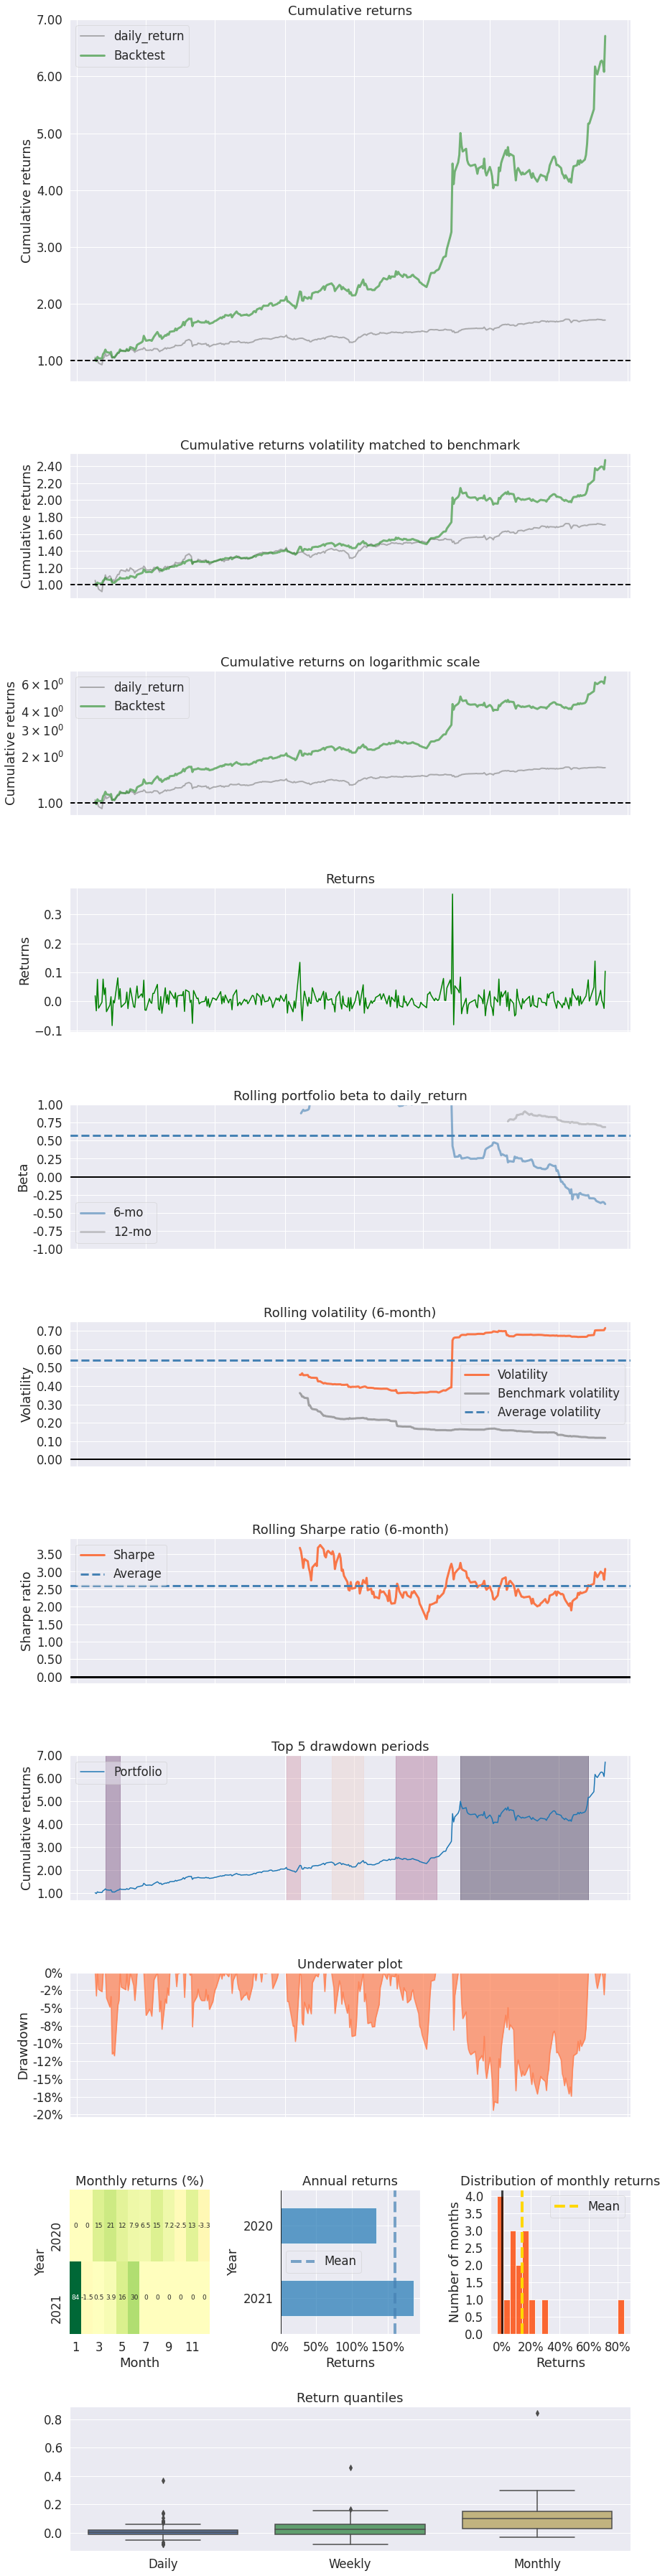

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

==============Compare to S&P 500===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


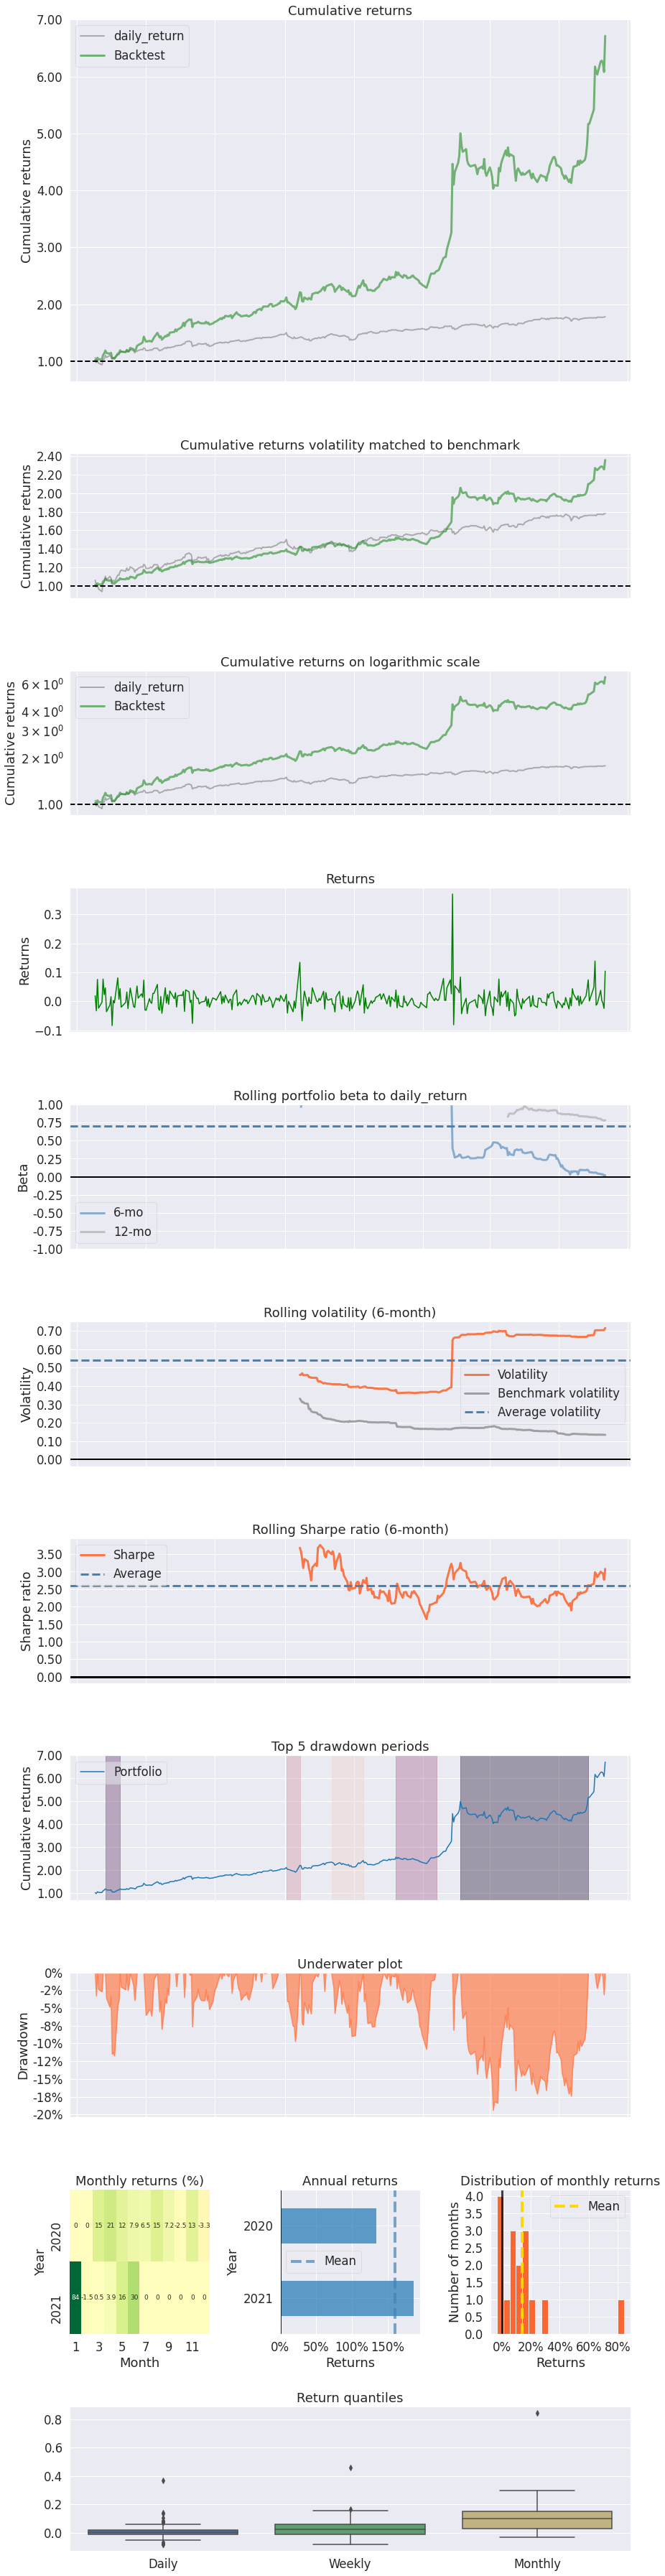

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

==============Compare to Nasdaq===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


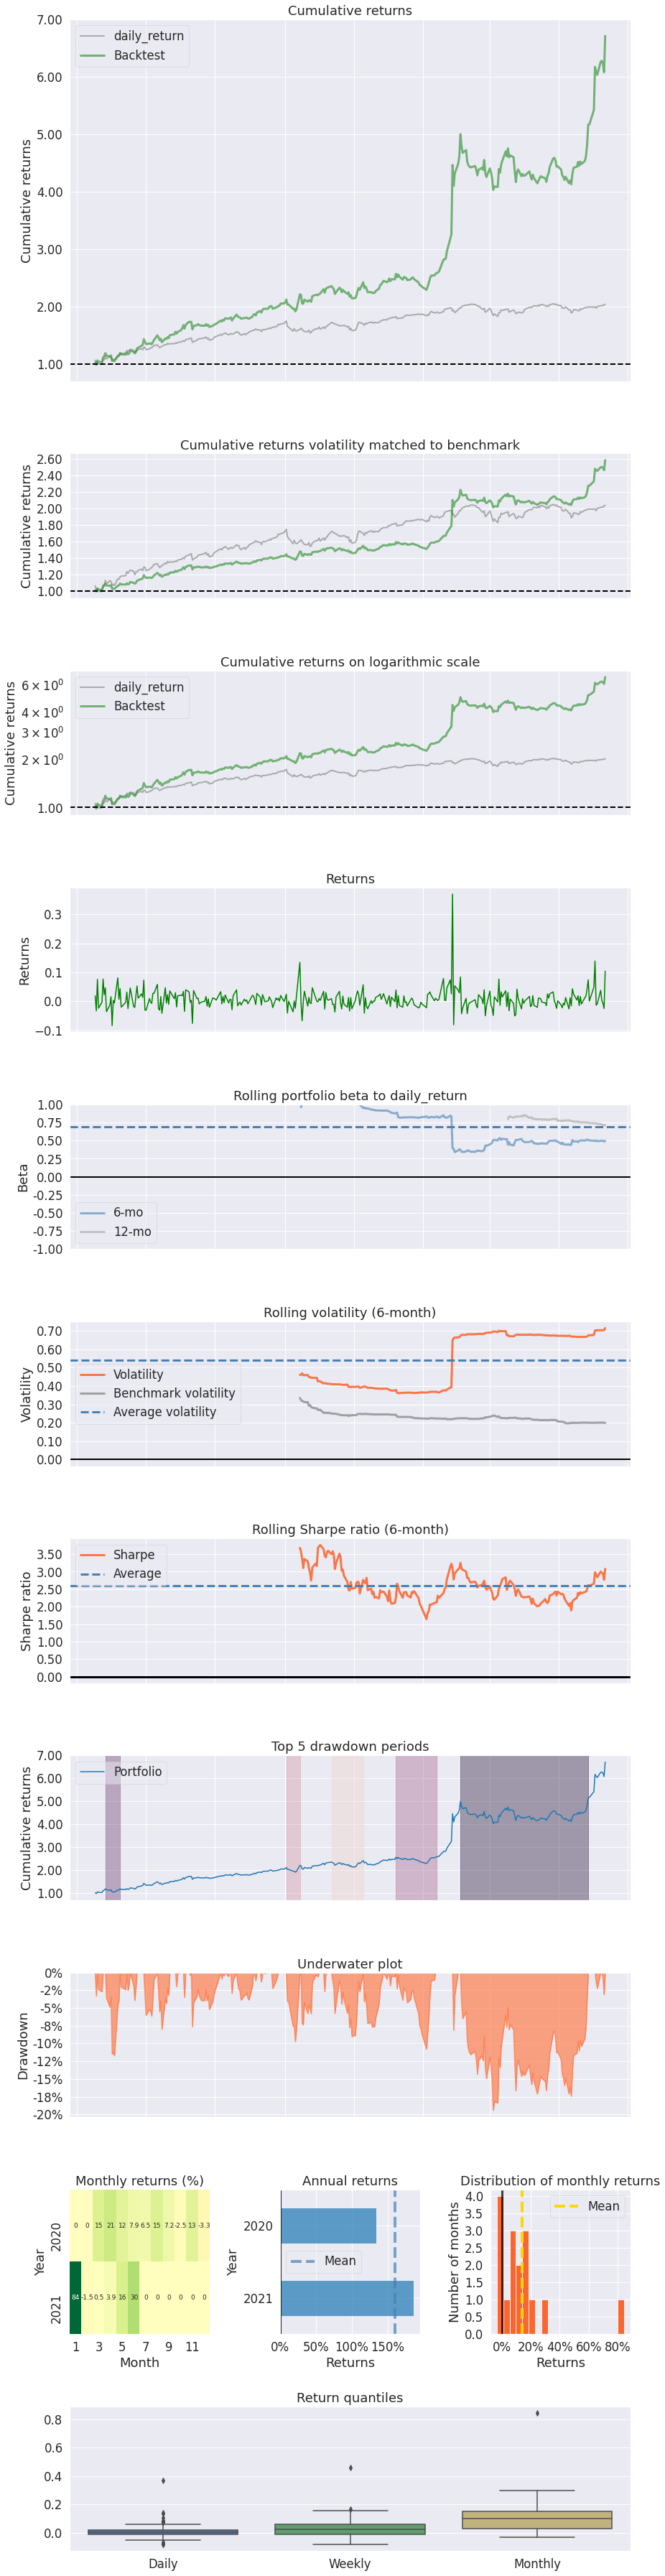

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

##**DDPG**

###**Train**

In [ ]:
DDPG_PARAMS = {"batch_size": 64, "buffer_size": 500000, "learning_rate": 0.0001}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=30000)

{'batch_size': 64, 'buffer_size': 500000, 'learning_rate': 0.0001}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_1
begin_total_asset:1000000
end_total_asset:1494029.9393311264
Sharpe:  0.5713292236861182
begin_total_asset:1000000
end_total_asset:1599082.1133174237
Sharpe:  0.6519857452275619
begin_total_asset:1000000
end_total_asset:1599082.1133174237
Sharpe:  0.6519857452275619
begin_total_asset:1000000
end_total_asset:1599082.1133174237
Sharpe:  0.6519857452275619
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 67        |
|    time_elapsed    | 55        |
|    total timesteps | 3772      |
| train/             |           |
|    actor_loss      | -6.09e+06 |
|    critic_loss     | 2.55e+11  |
|    learning_rate   | 0.0001    |
|    n_updates       | 2829      |
----------------------------------
begin_total_asset:1000000
end_total_asset:1599082.1133174237
Sharpe:  0.6519857452275619
begin_total_

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:7328017.037336795
Sharpe:  2.9116865125255456
hit end!


###**Backtest**

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============DDPG Strategy Stats===========")
perf_stats_all

==============DDPG Strategy Stats===========


Annual return           3.945304
Cumulative returns      6.328017
Annual volatility       0.608219
Sharpe ratio            2.911687
Calmar ratio           26.391600
Stability               0.918215
Max drawdown           -0.149491
Omega ratio             1.885282
Sortino ratio           6.565660
Skew                    4.453770
Kurtosis               46.899427
Tail ratio              1.800680
Daily value at risk    -0.069601
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to 	Dow 30===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


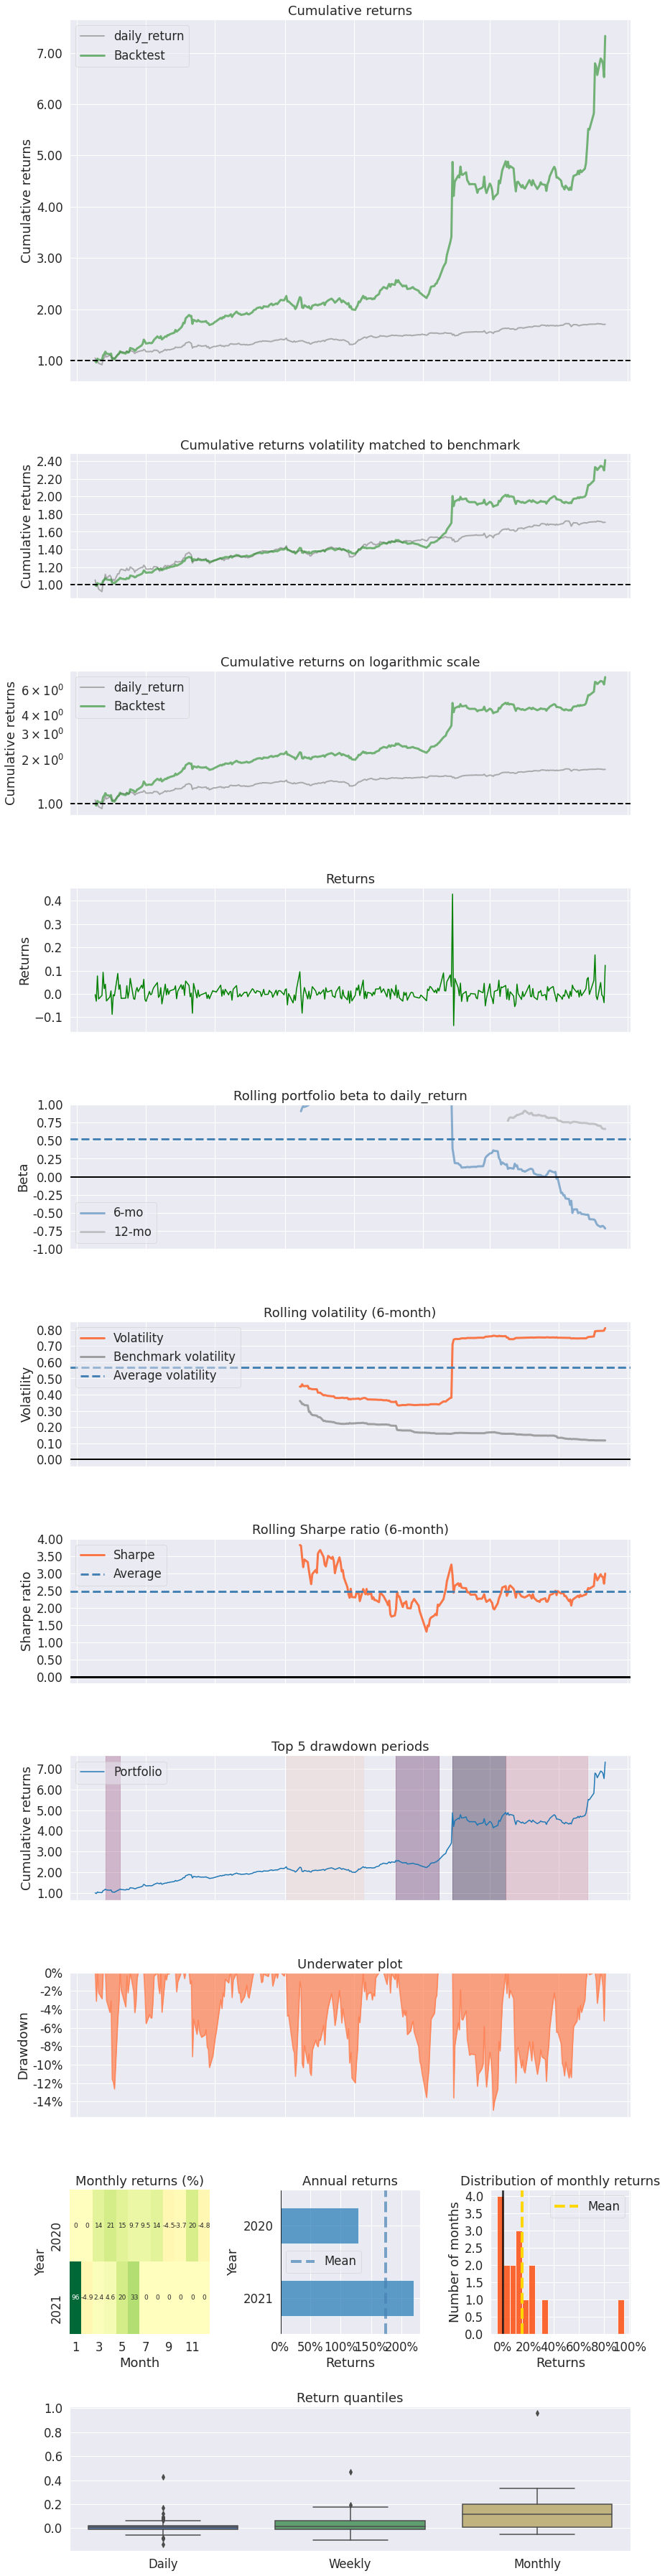

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to S&P 500===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


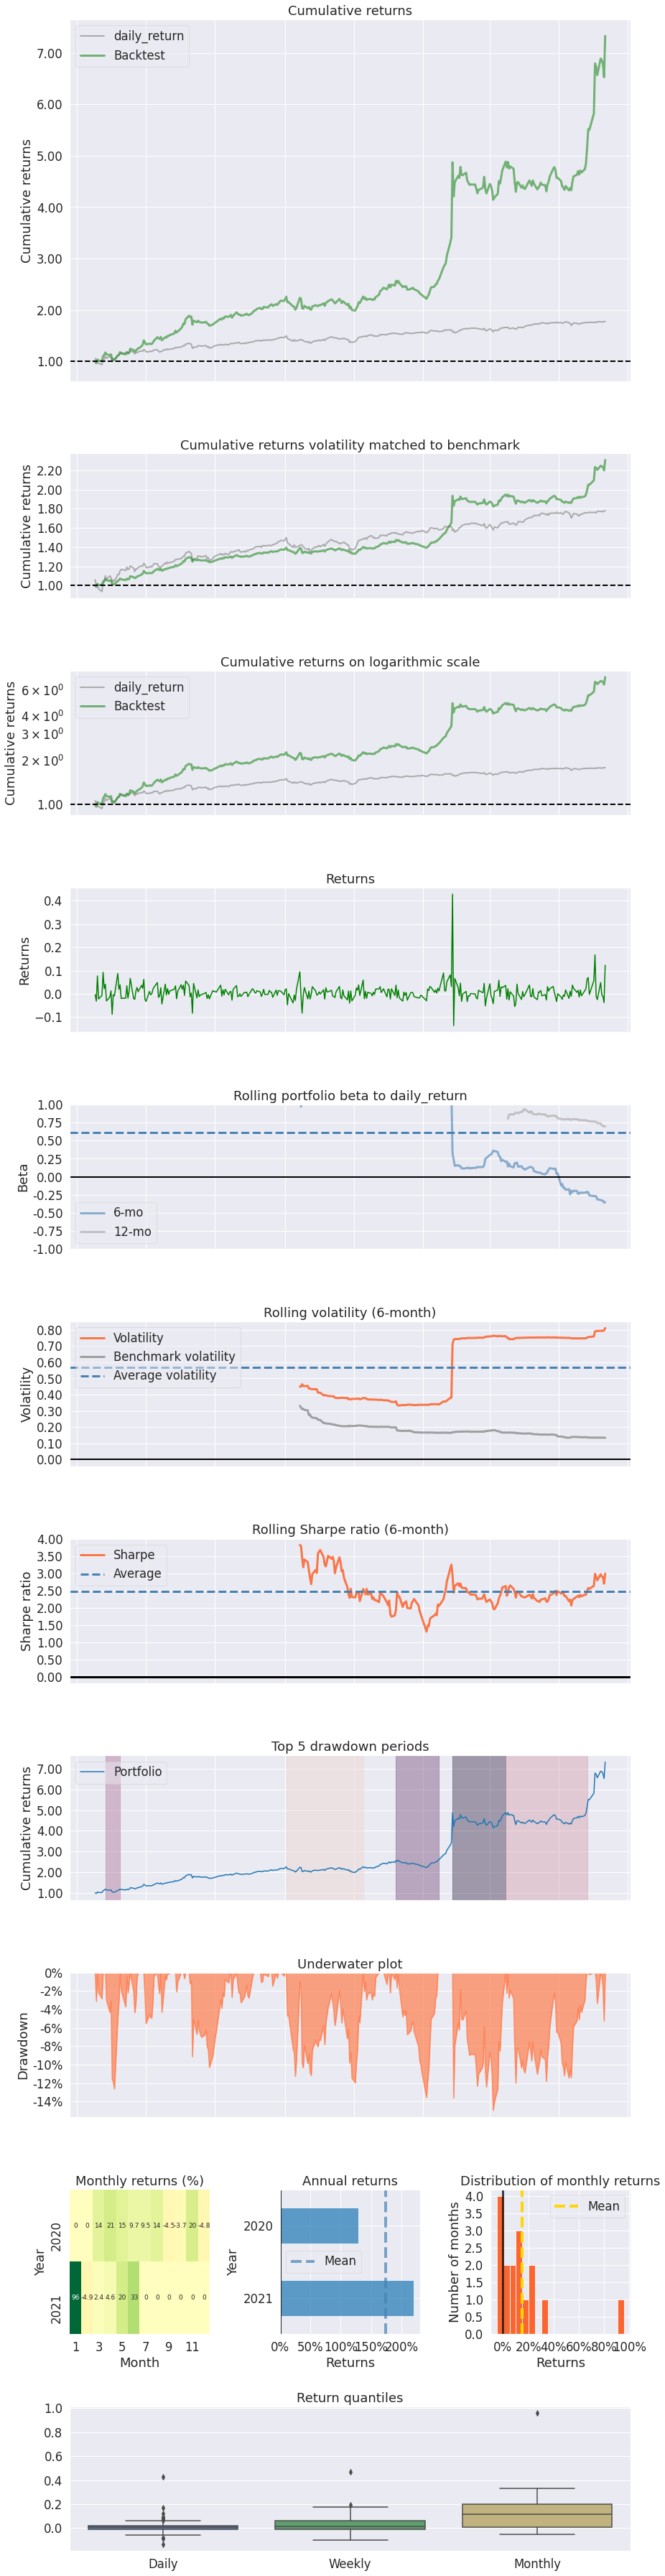

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to Nasdaq===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


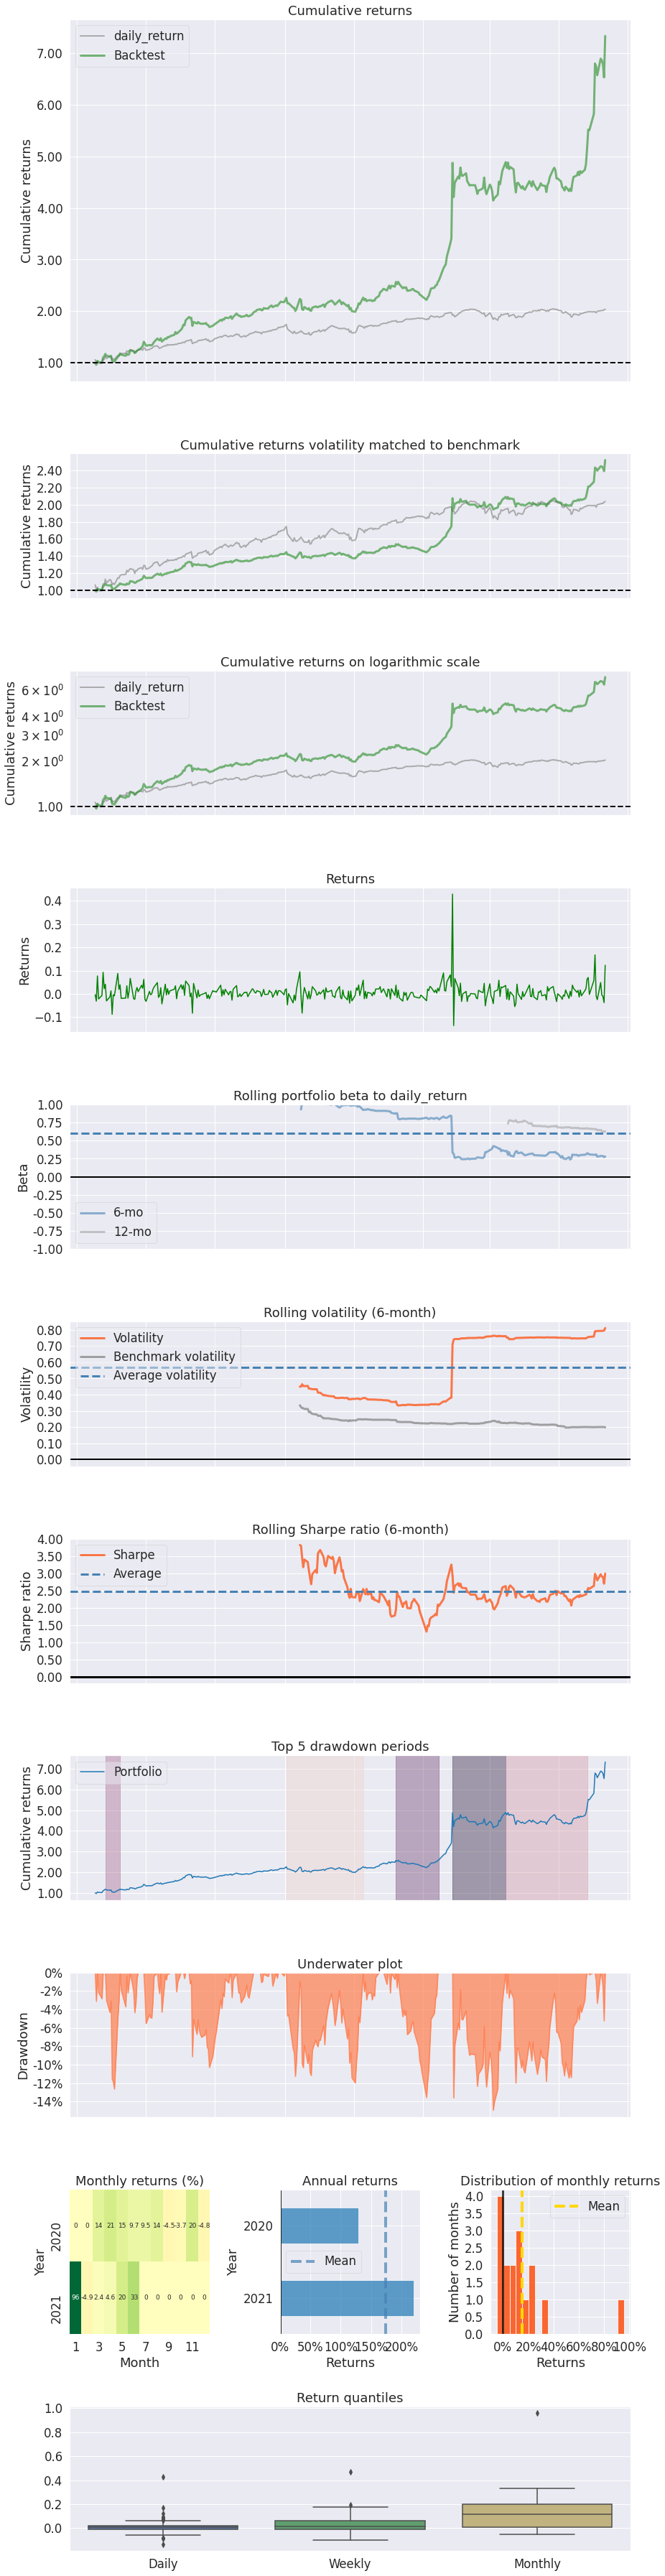

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

##**PPO**

###**Train**

In [ ]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_1
begin_total_asset:1000000
end_total_asset:1695463.5152018012
Sharpe:  0.6793679970251278
begin_total_asset:1000000
end_total_asset:1867363.0074503508
Sharpe:  0.772484736831656
-----------------------------
| time/              |      |
|    fps             | 492  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
begin_total_asset:1000000
end_total_asset:2028167.348319303
Sharpe:  0.8589976475602215
begin_total_asset:1000000
end_total_asset:1768927.2146979377
Sharpe:  0.7039984422312924
-------------------------------------------
| time/                   |               |
|    fps                  | 460           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 4096          |
| train/                  |          

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:9169917.131111506
Sharpe:  3.3262948517939717
hit end!


###**Backtest**

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============PPO Strategy Stats===========")
perf_stats_all

==============PPO Strategy Stats===========


Annual return           4.920307
Cumulative returns      8.169917
Annual volatility       0.582758
Sharpe ratio            3.326295
Calmar ratio           33.766479
Stability               0.961962
Max drawdown           -0.145716
Omega ratio             2.063704
Sortino ratio           7.953412
Skew                    4.462053
Kurtosis               43.252442
Tail ratio              1.746258
Daily value at risk    -0.065728
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to 	Dow 30===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


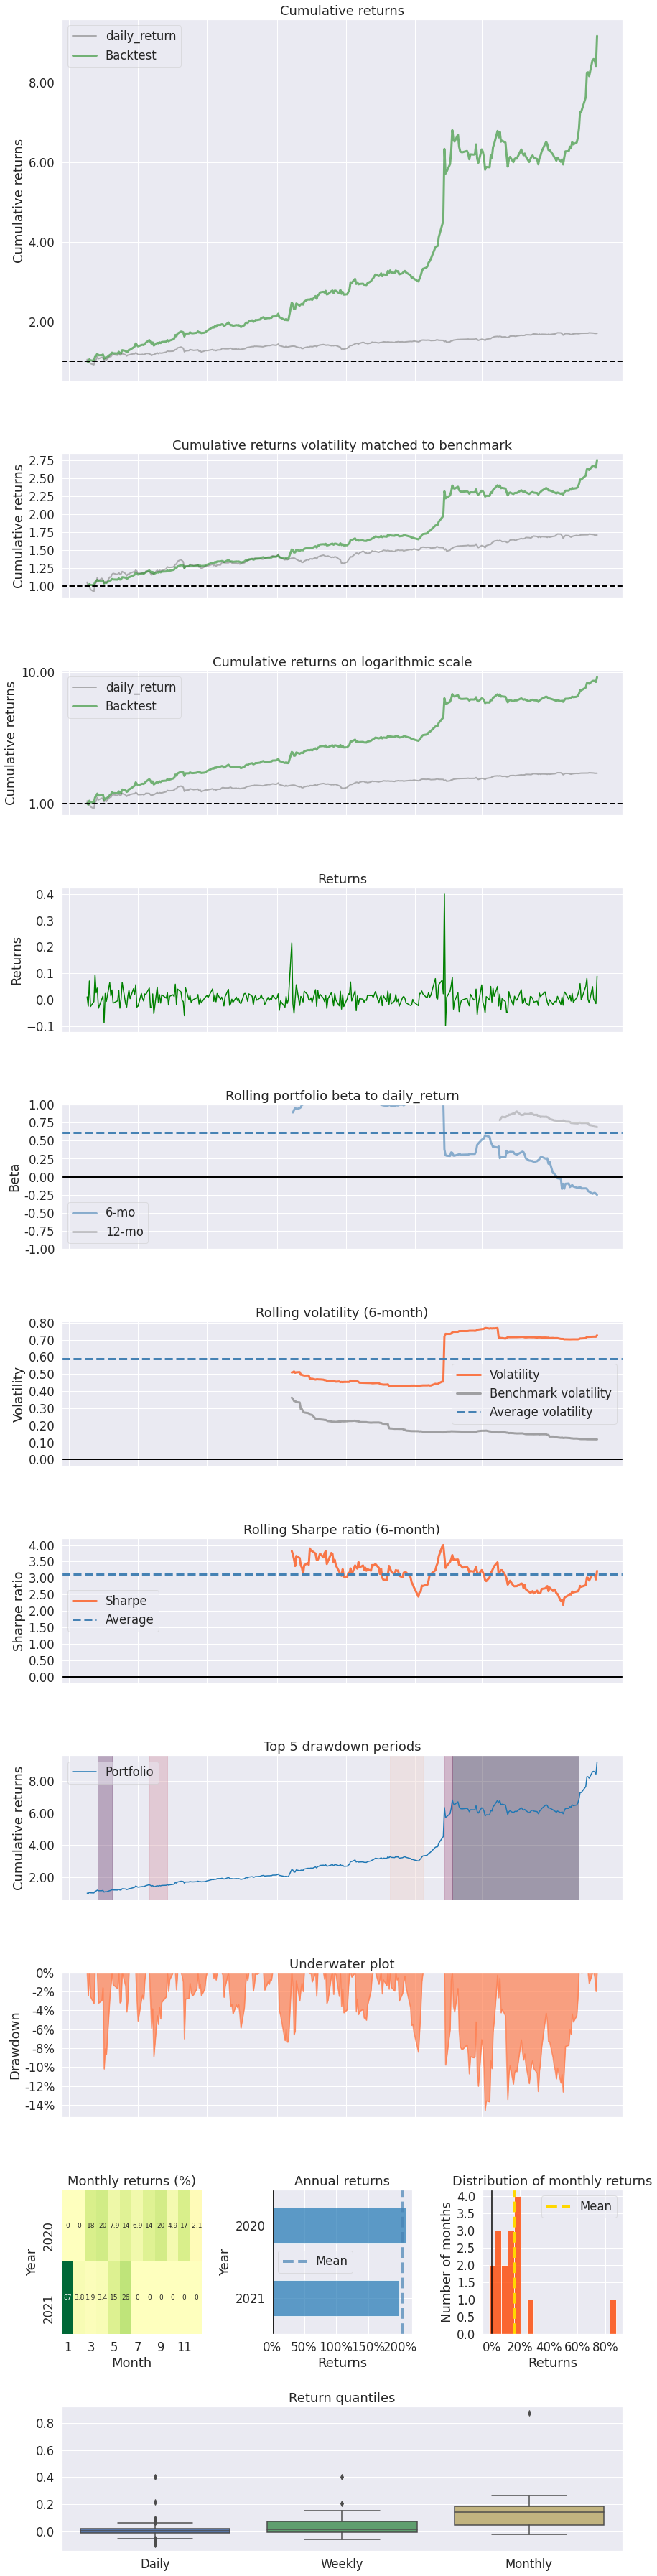

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to S&P 500===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


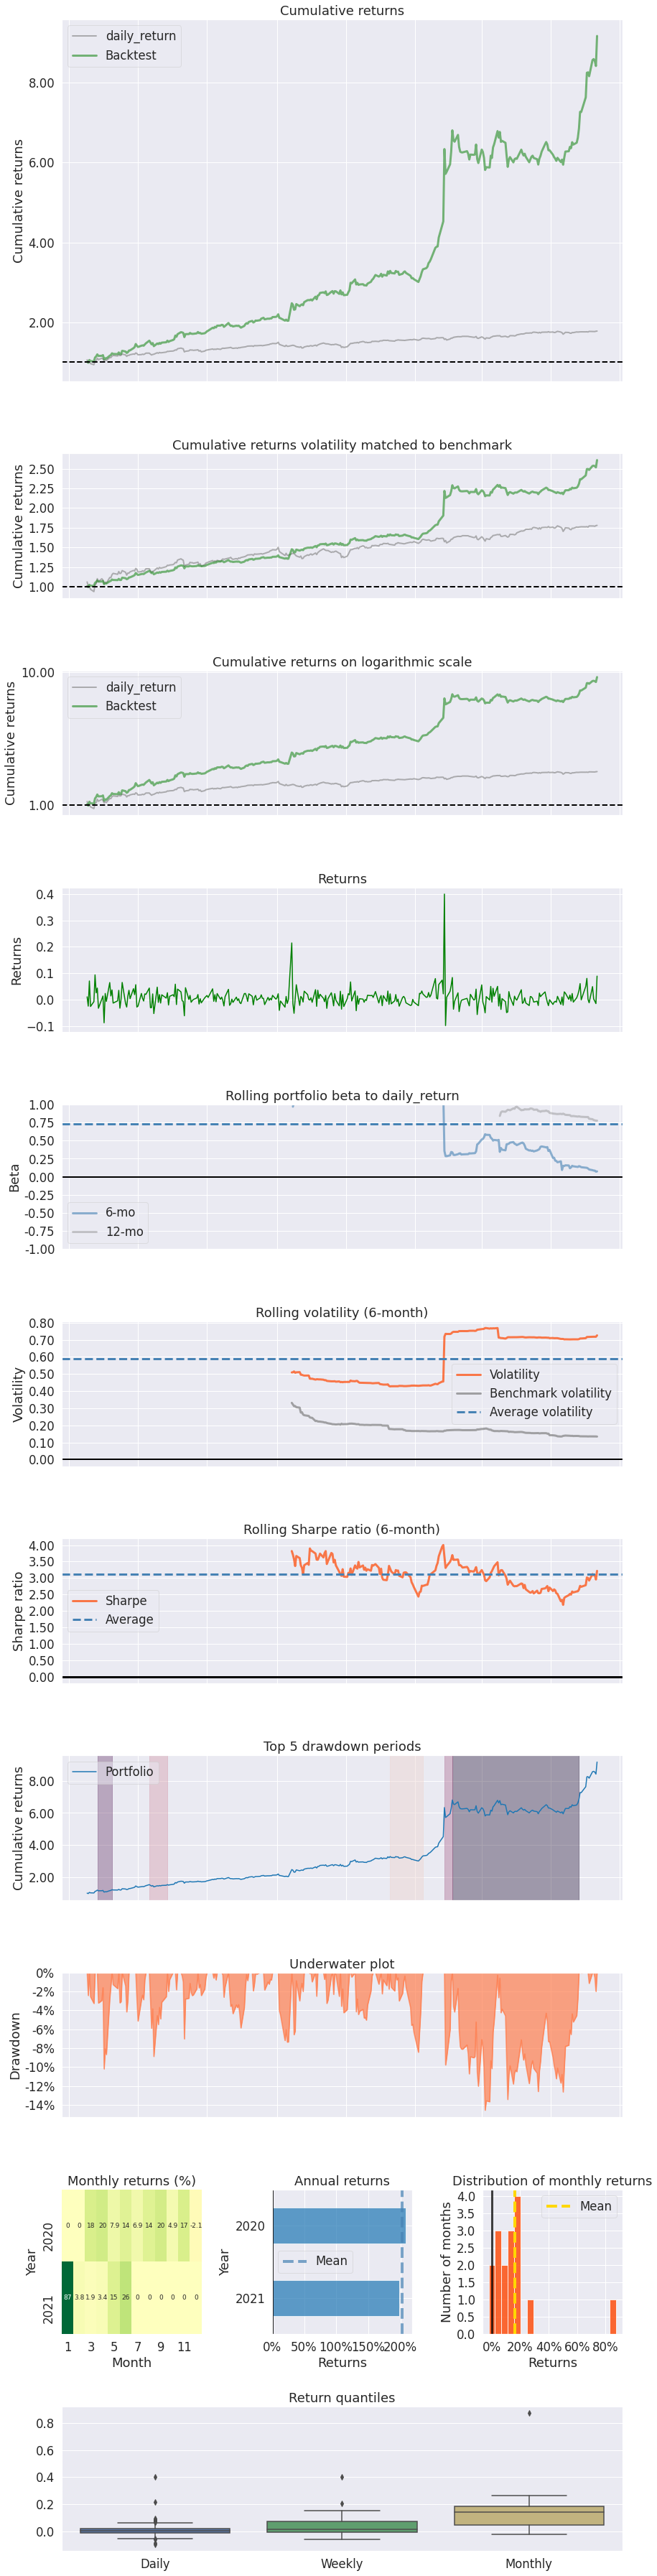

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to Nasdaq===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


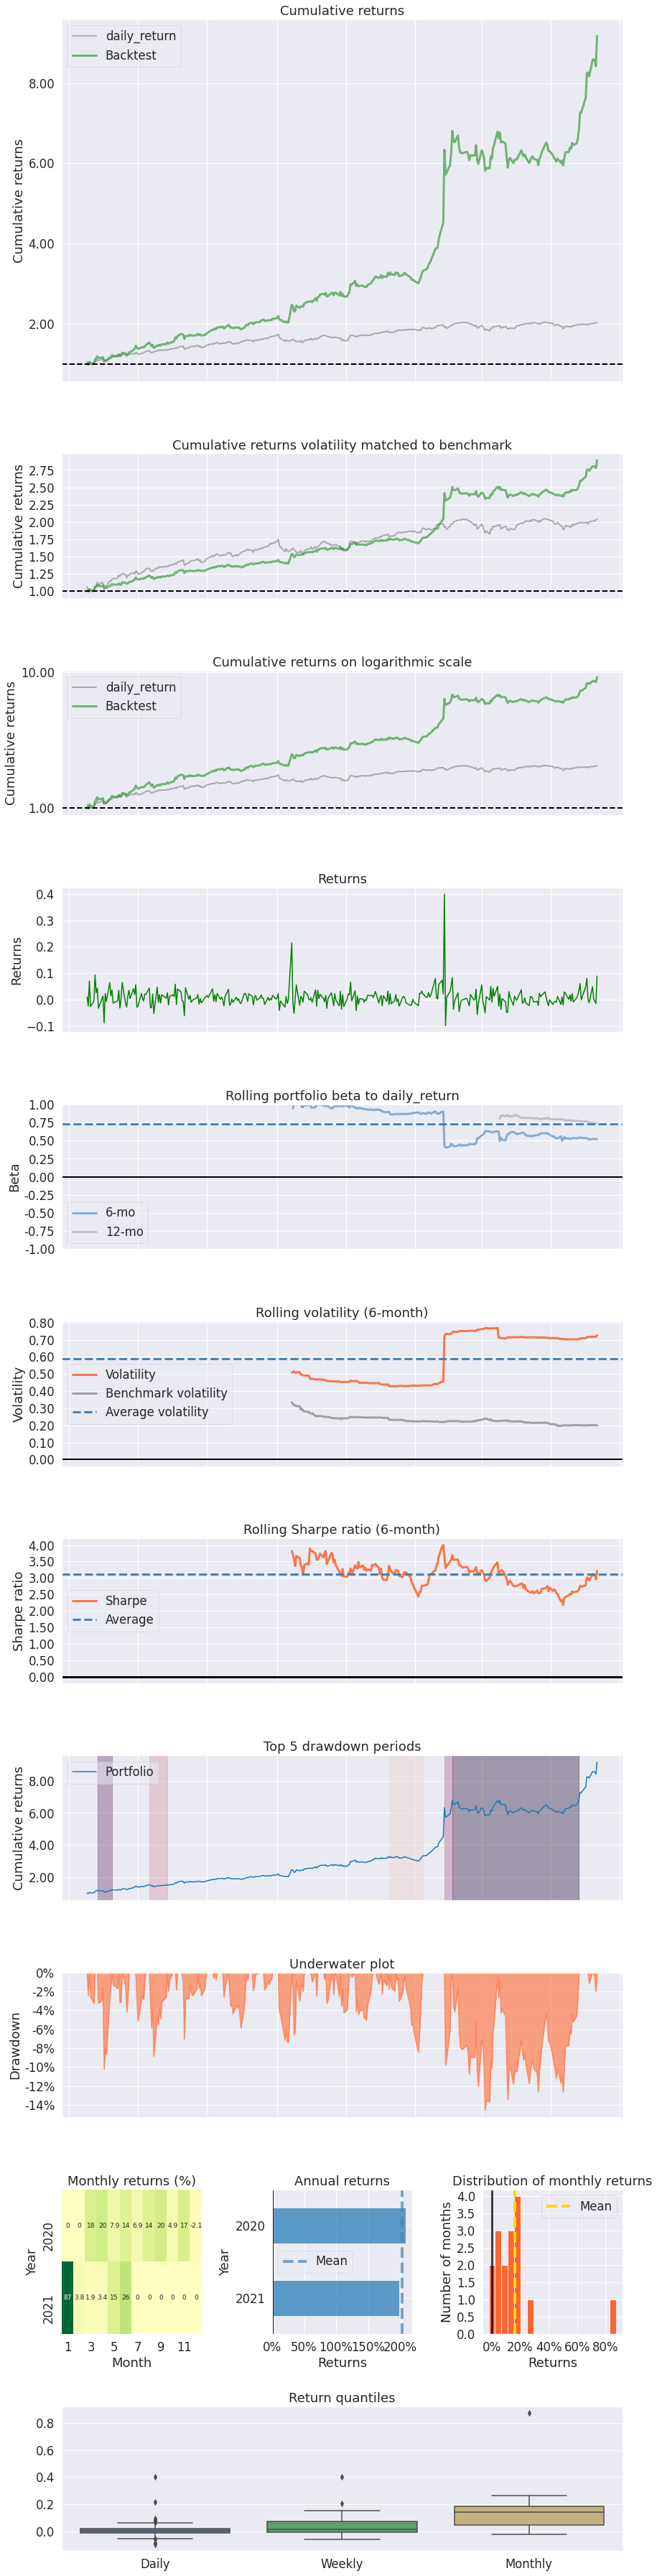

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

##**TD3**

###**Train**

In [ ]:
TD3_PARAMS = {"batch_size": 128, 
              "buffer_size": 1000000, 
              "learning_rate": 0.0003}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0003}
Using cpu device
Logging to tensorboard_log/td3/td3_1
begin_total_asset:1000000
end_total_asset:2346534.4213252557
Sharpe:  0.8860504194850847
begin_total_asset:1000000
end_total_asset:2836874.493903856
Sharpe:  0.9954167253098332
begin_total_asset:1000000
end_total_asset:2836874.493903856
Sharpe:  0.9954167253098332
begin_total_asset:1000000
end_total_asset:2836874.493903856
Sharpe:  0.9954167253098332
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 54        |
|    time_elapsed    | 68        |
|    total timesteps | 3772      |
| train/             |           |
|    actor_loss      | -8.04e+06 |
|    critic_loss     | 2.9e+11   |
|    learning_rate   | 0.0003    |
|    n_updates       | 2829      |
----------------------------------
begin_total_asset:1000000
end_total_asset:2836874.493903856
Sharpe:  0.9954167253098332
begin_total_asse

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_td3,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:6507746.935016989
Sharpe:  3.2975892362111483
hit end!


###**Backtest**

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============TD3 Strategy Stats===========")
perf_stats_all

==============TD3 Strategy Stats===========


Annual return           3.495903
Cumulative returns      5.507747
Annual volatility       0.492288
Sharpe ratio            3.297589
Calmar ratio           24.193721
Stability               0.949506
Max drawdown           -0.144496
Omega ratio             1.924819
Sortino ratio           6.933453
Skew                    2.039277
Kurtosis               11.595899
Tail ratio              1.626667
Daily value at risk    -0.055581
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to 	Dow 30===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


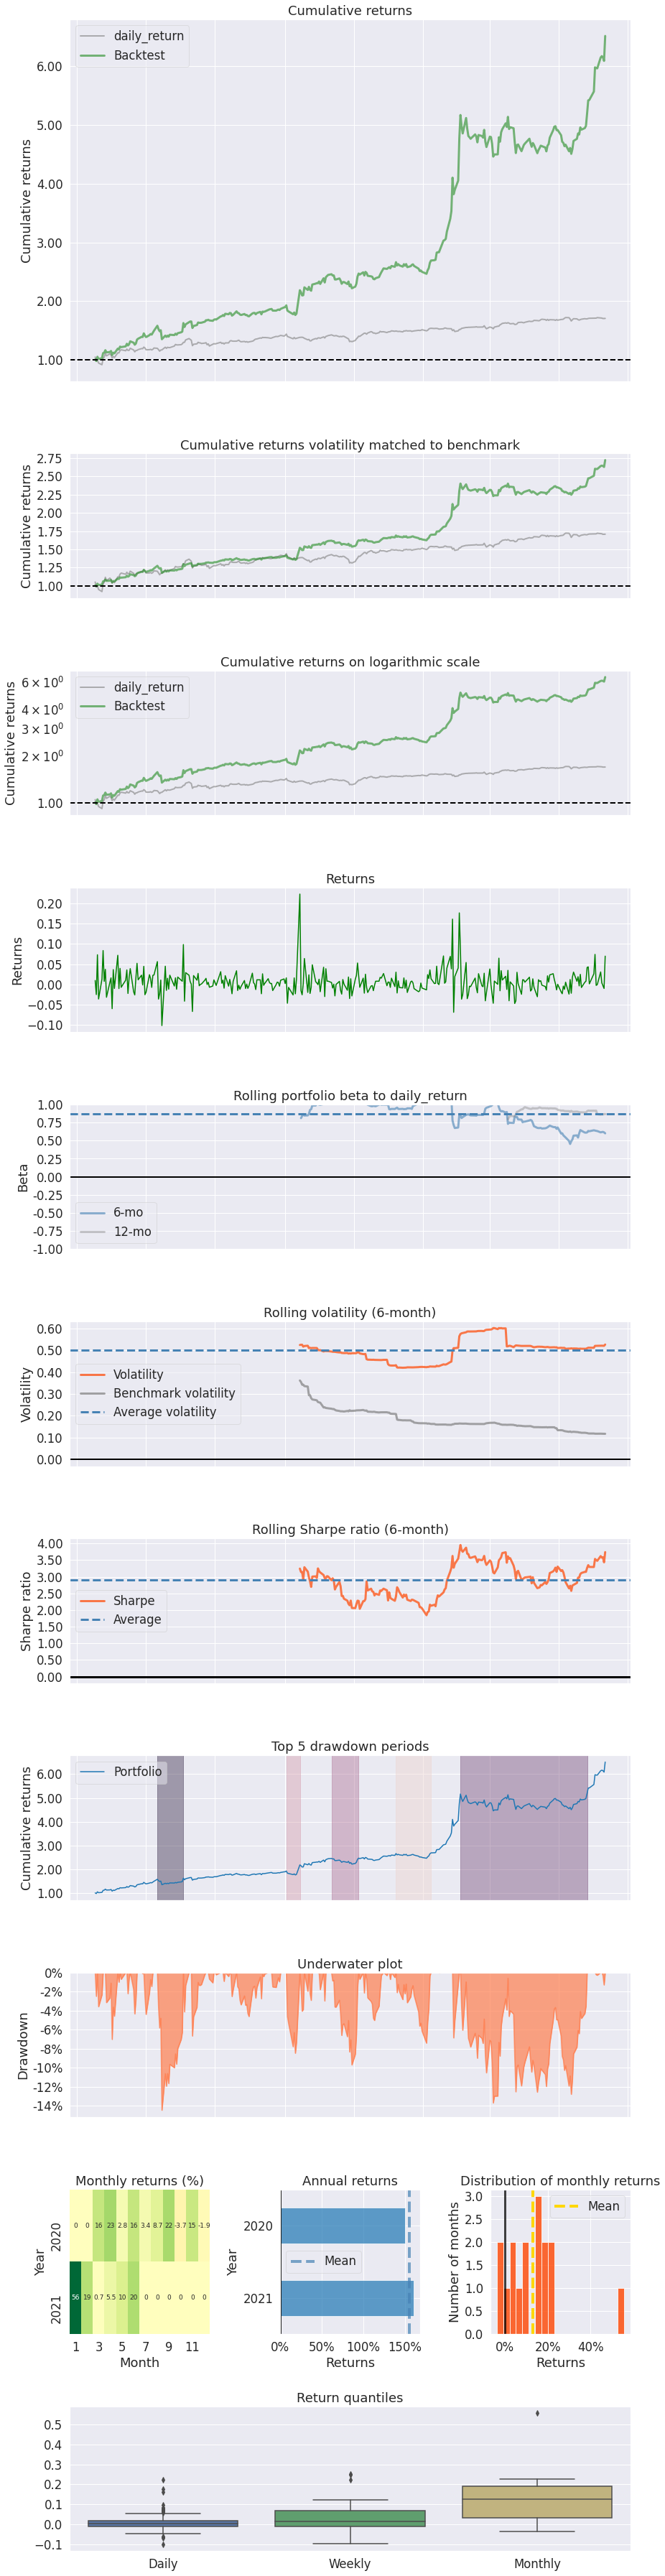

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to S&P 500===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


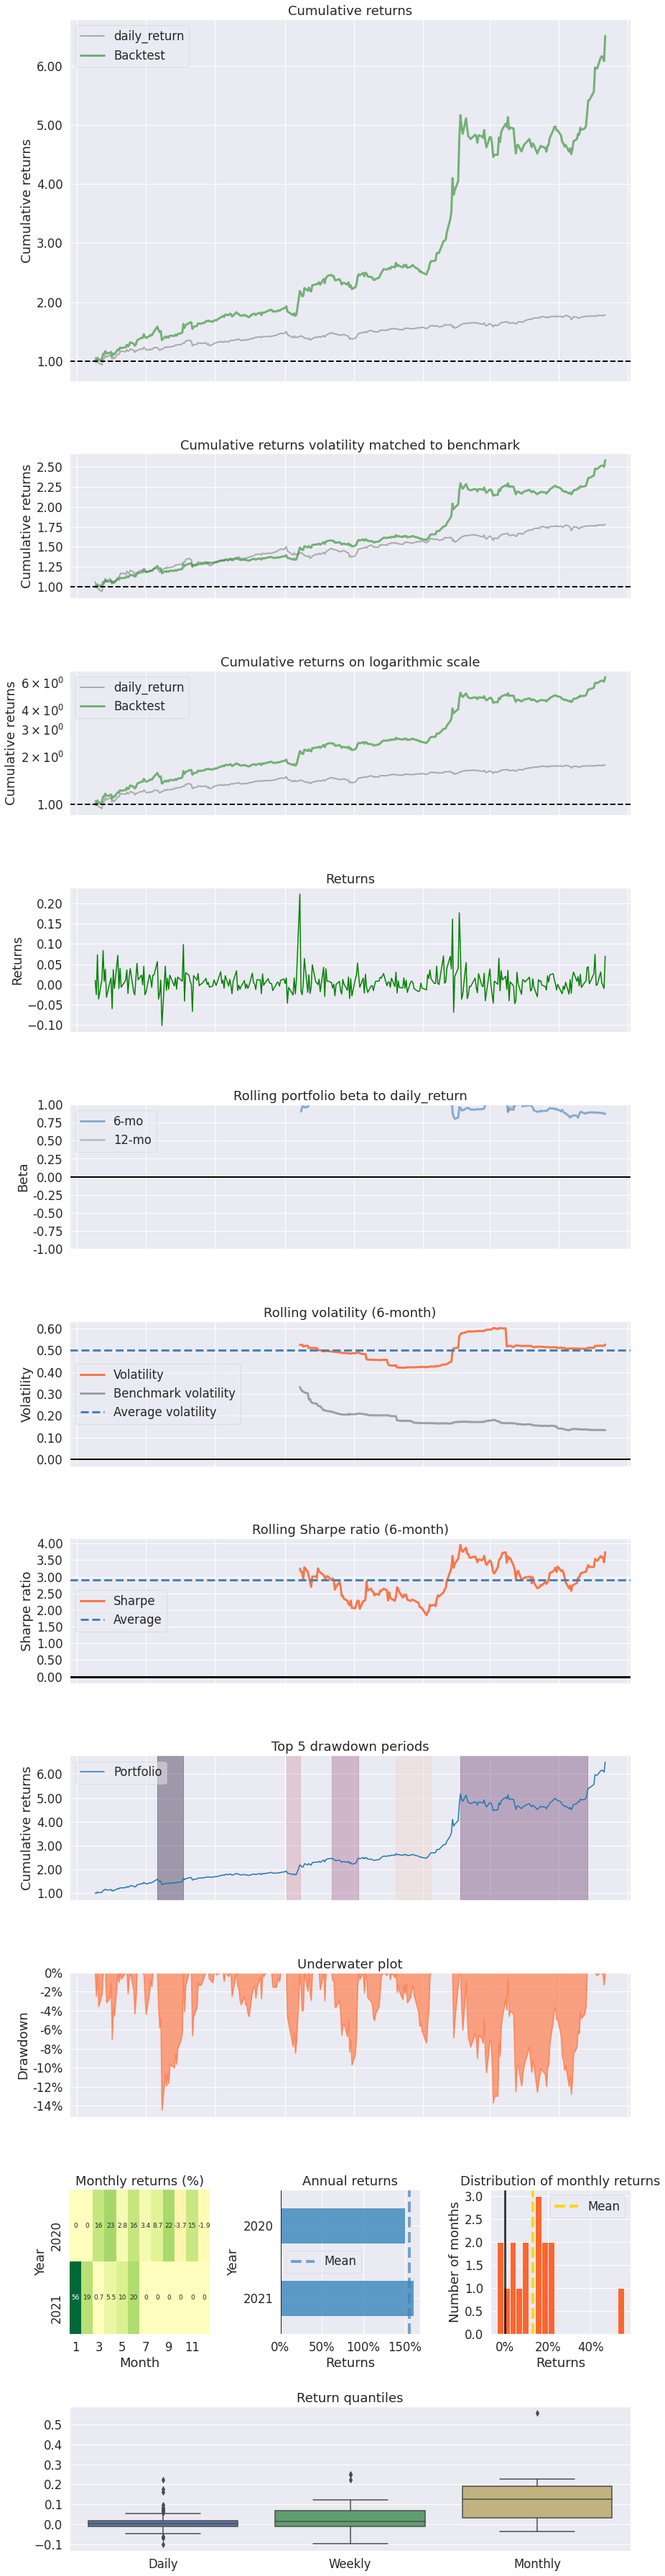

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to Nasdaq===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


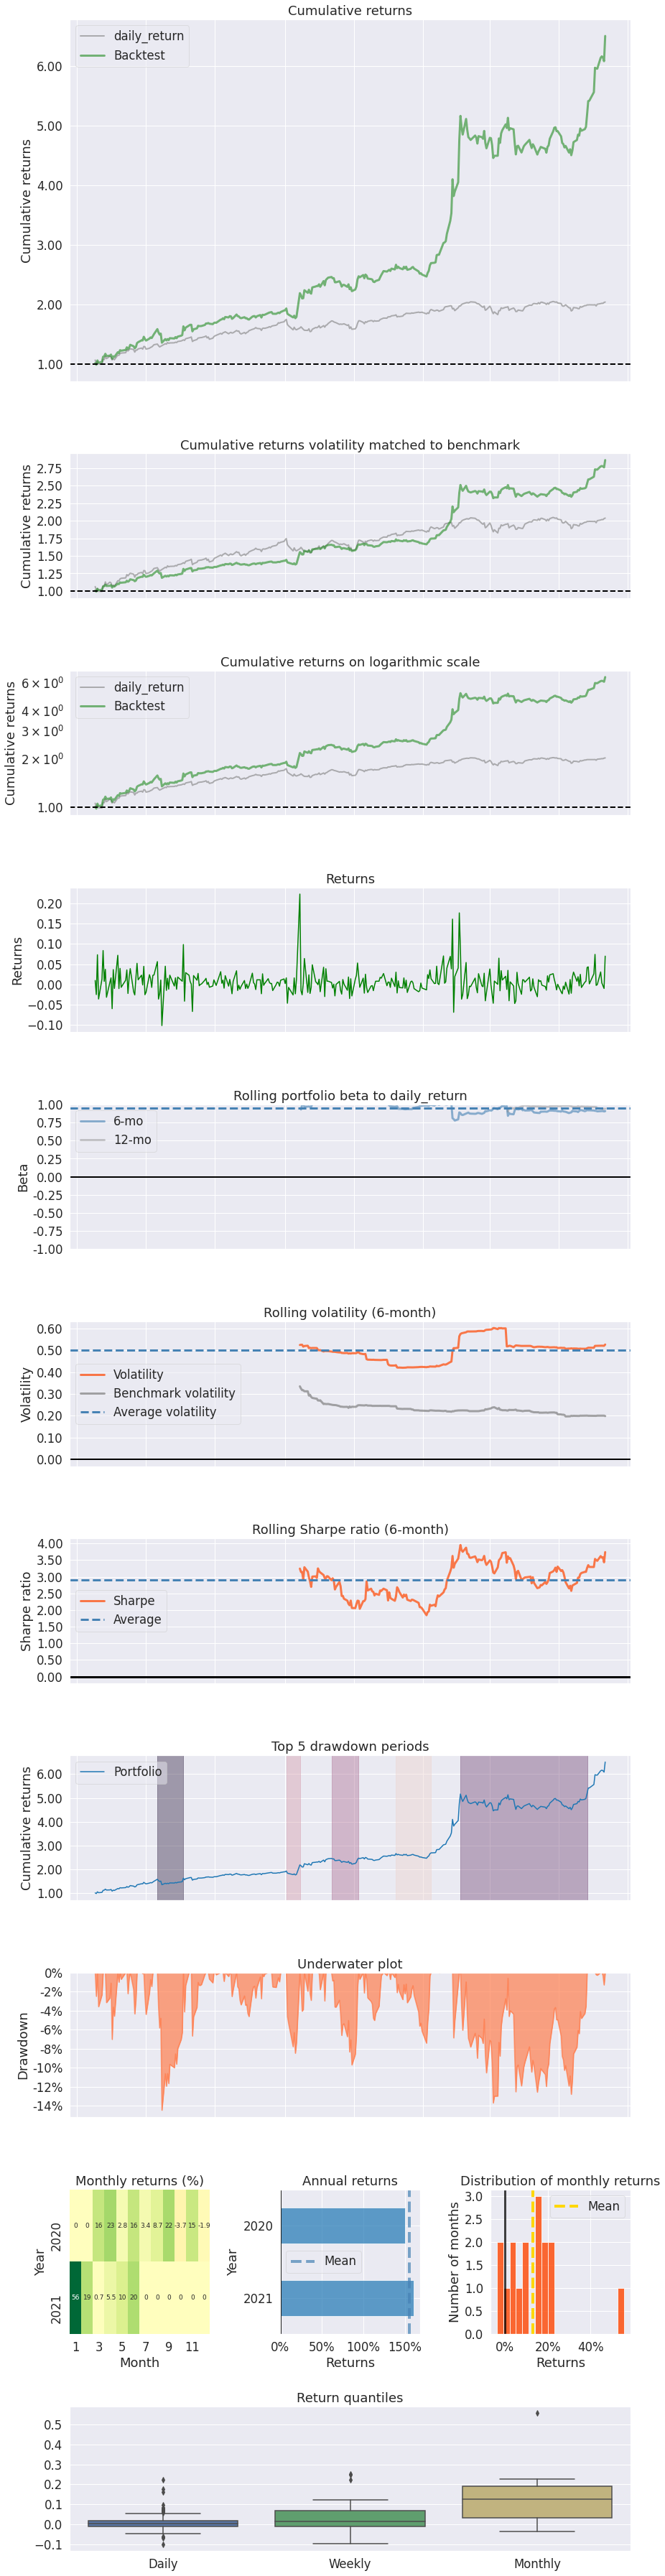

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

##**SAC**

###**Train**

In [ ]:
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=30000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac/sac_1
begin_total_asset:1000000
end_total_asset:2067294.809760659
Sharpe:  0.8169976477312961
begin_total_asset:1000000
end_total_asset:1813825.4968280264
Sharpe:  0.6933551722074798
begin_total_asset:1000000
end_total_asset:1813649.5240968538
Sharpe:  0.6932518014226784
begin_total_asset:1000000
end_total_asset:1813772.6631260235
Sharpe:  0.6933141119443204
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 42        |
|    time_elapsed    | 87        |
|    total timesteps | 3772      |
| train/             |           |
|    actor_loss      | -7.98e+06 |
|    critic_loss     | 3.16e+11  |
|    ent_coef        | 0.151     |
|    ent_coef_loss   | 184       |
|    learning_rate   | 0.0001    |
|    n_updates       | 3671      |
--------------------

###**Trade**

In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,environment= e_trade_gym)

begin_total_asset:1000000
end_total_asset:7920147.528871135
Sharpe:  3.2650816461693664
hit end!


###**Backtest**

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=DRL_strat, 
                              factor_returns=DRL_strat,
                                positions=None, transactions=None, turnover_denom="AGB")

print("==============SAC Strategy Stats===========")
perf_stats_all

==============SAC Strategy Stats===========


Annual return           4.263521
Cumulative returns      6.920148
Annual volatility       0.553942
Sharpe ratio            3.265082
Calmar ratio           32.731750
Stability               0.937731
Max drawdown           -0.130256
Omega ratio             1.955460
Sortino ratio           7.387554
Skew                    3.334584
Kurtosis               27.612573
Tail ratio              1.666076
Daily value at risk    -0.062613
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to 	Dow 30===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


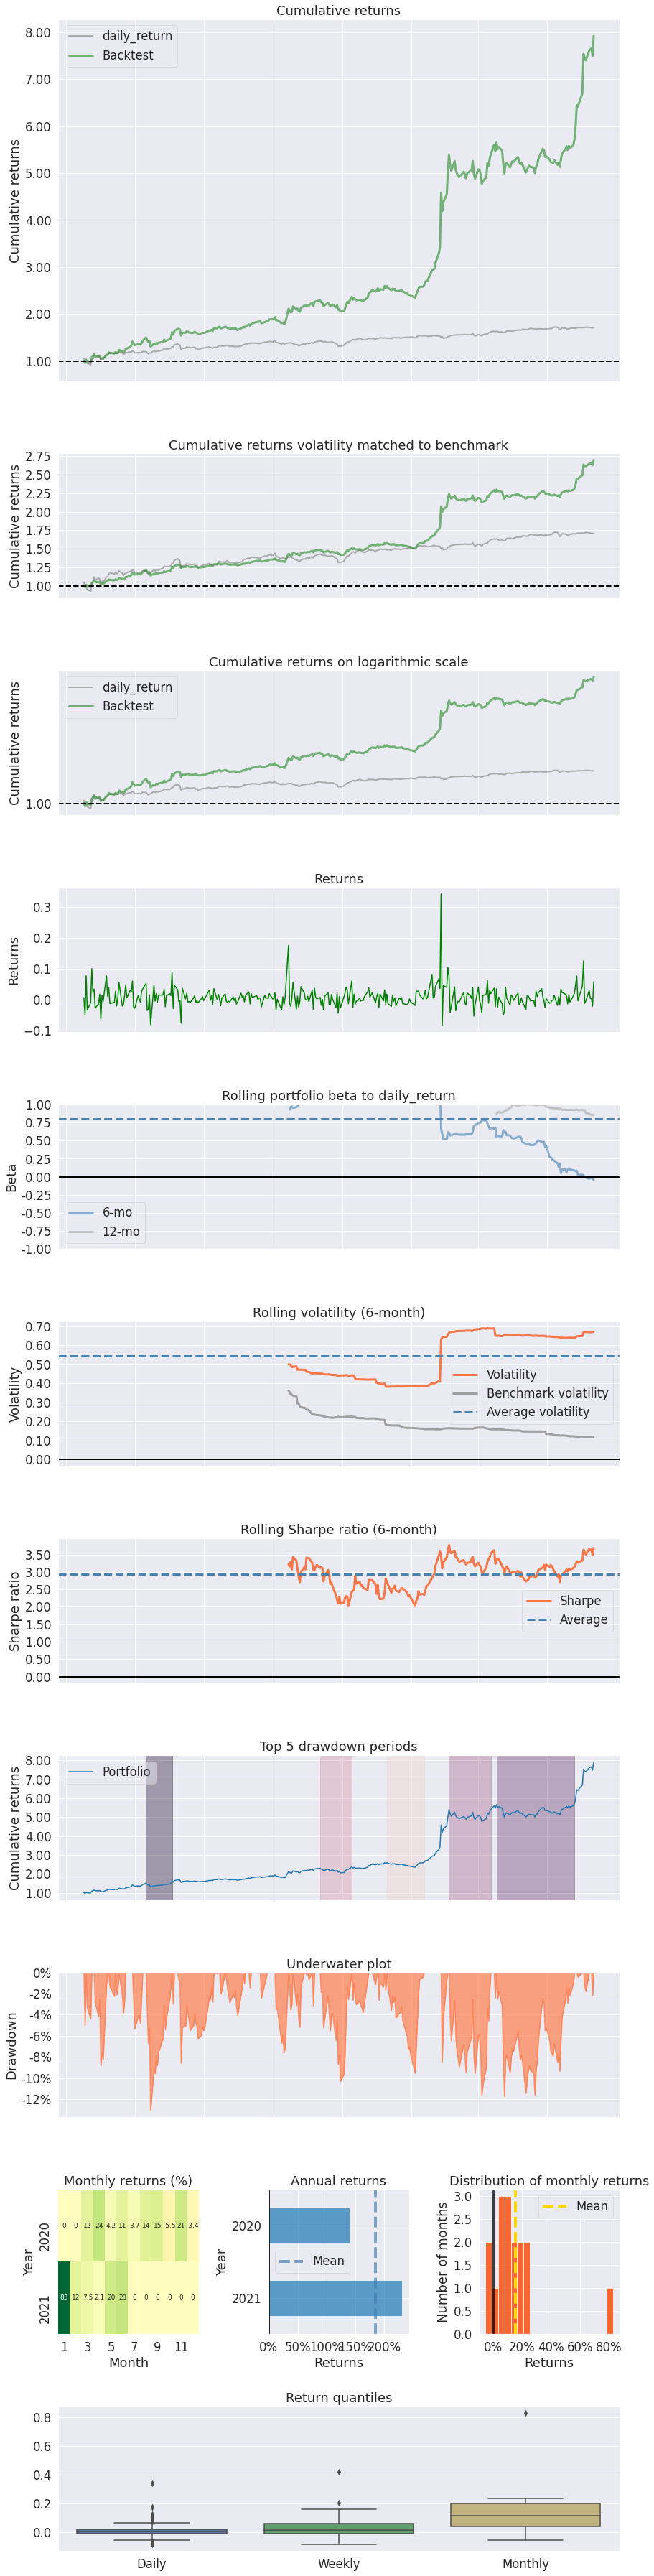

In [ ]:
baseline_df = get_baseline(
        ticker='^DJI', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to 	Dow 30===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to S&P 500===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


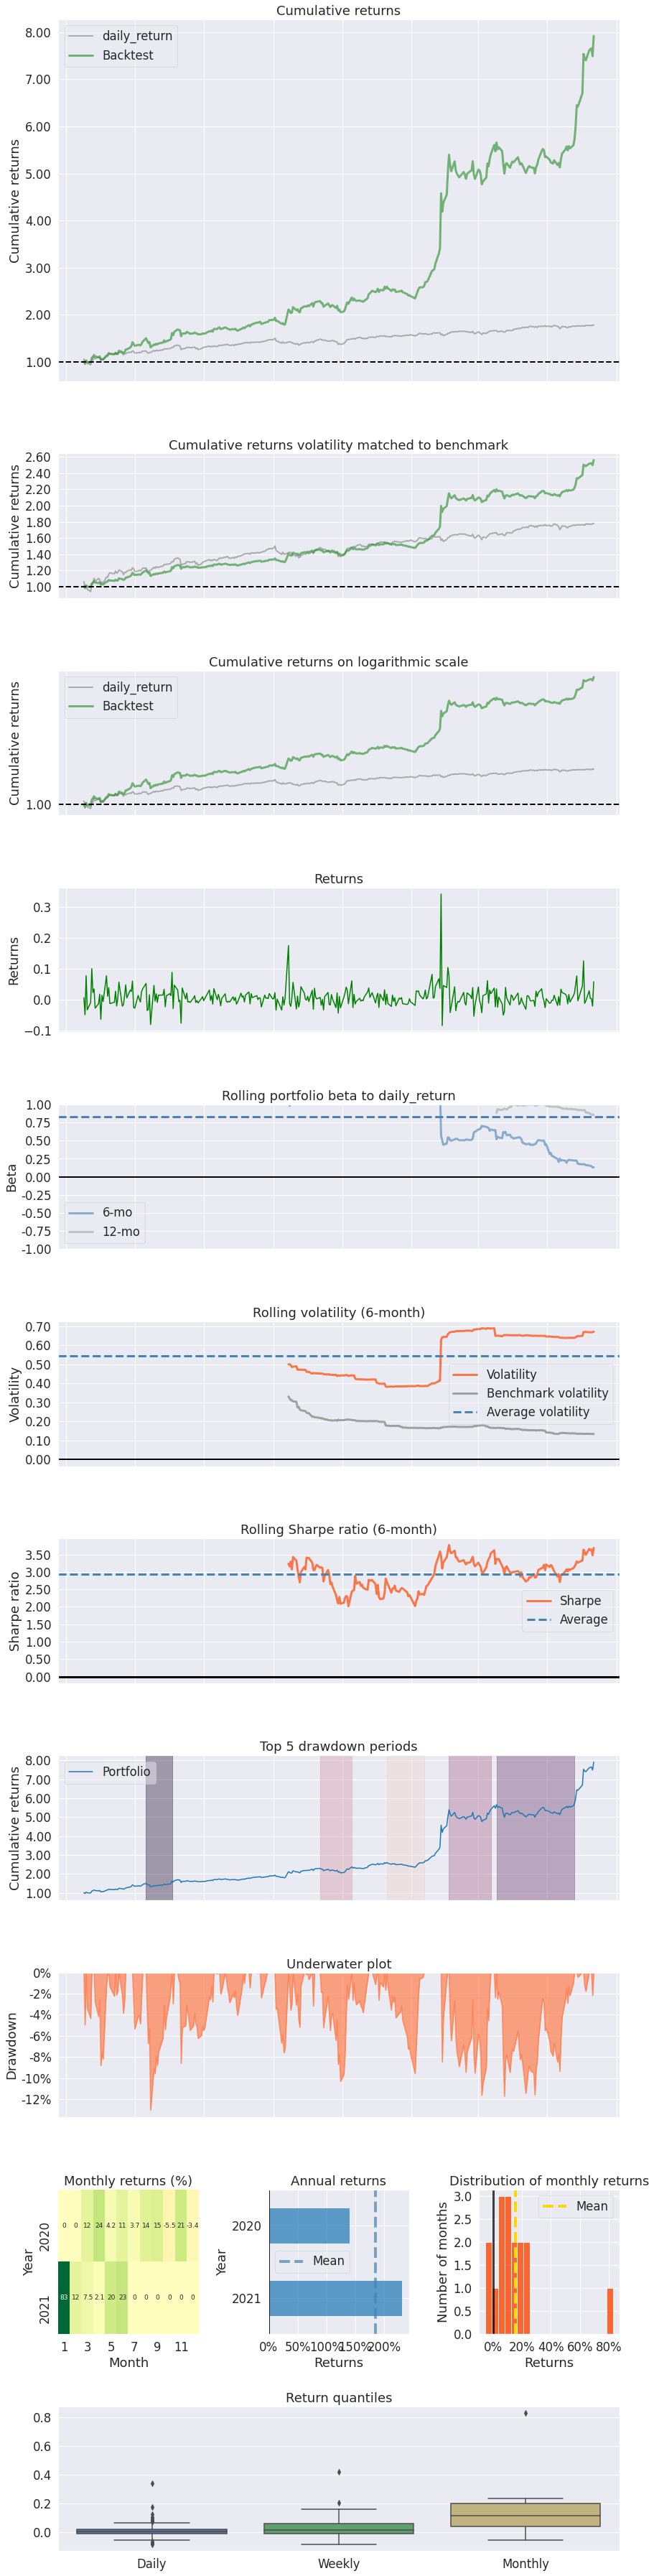

In [ ]:
baseline_df = get_baseline(
        ticker='^GSPC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline
print("==============Compare to S&P 500===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
==============Compare to Nasdaq===========


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


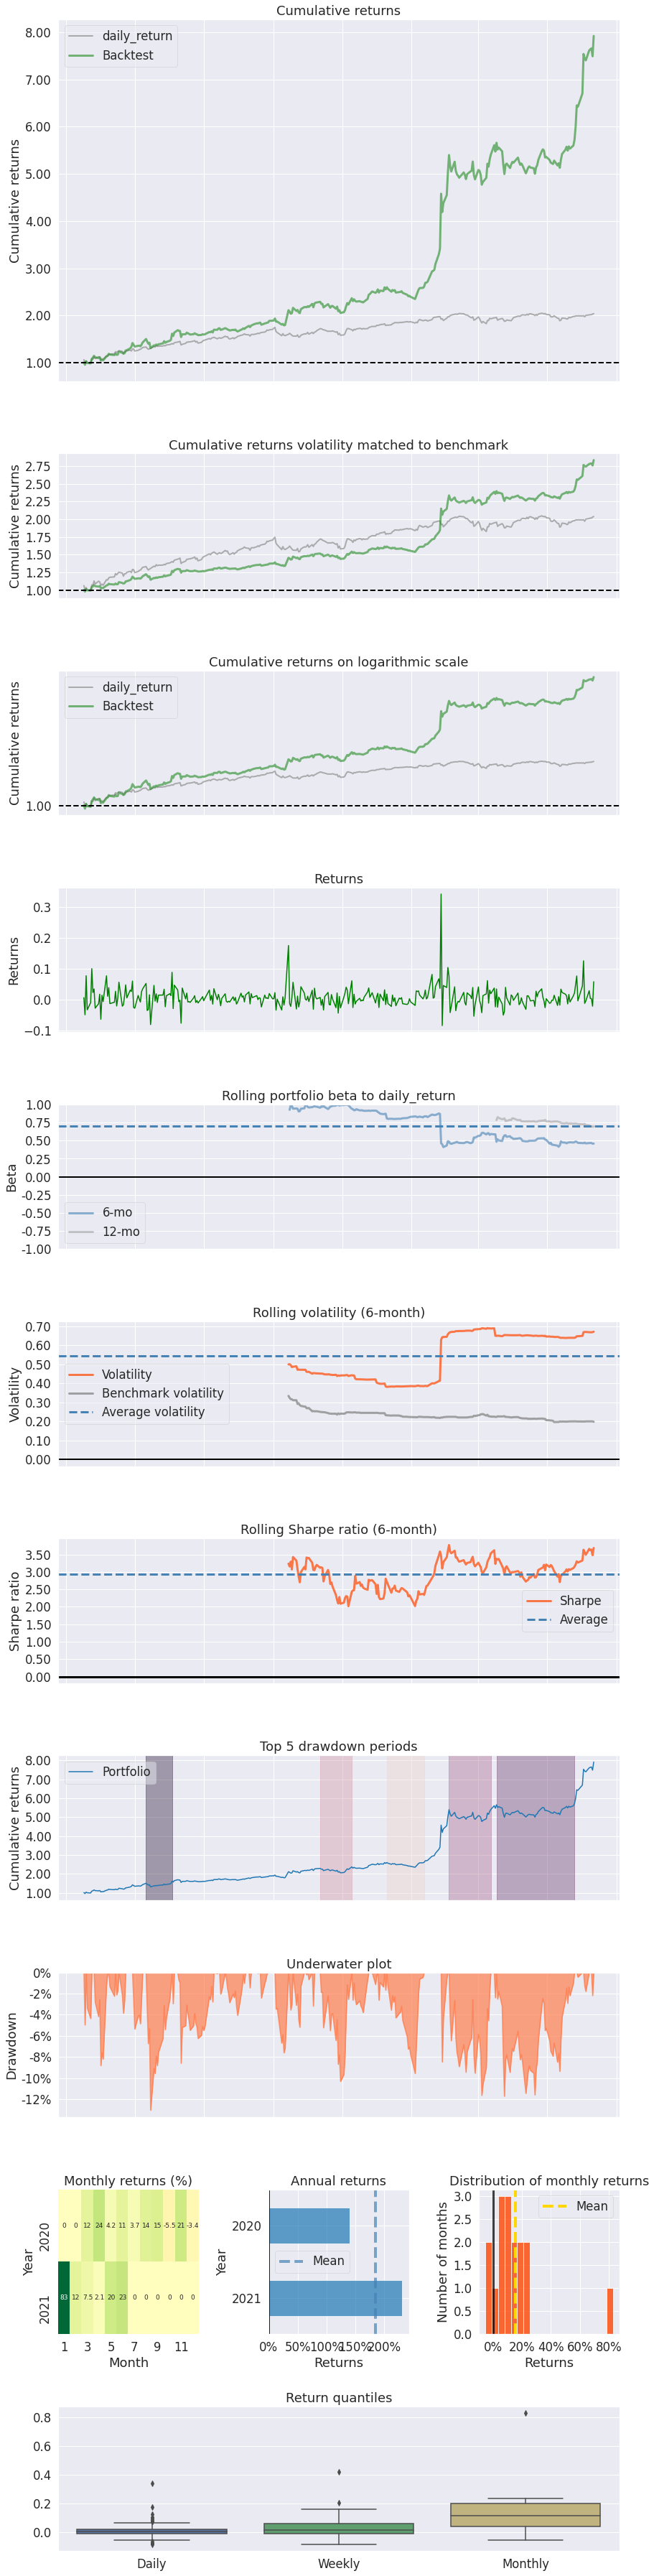

In [ ]:
baseline_df = get_baseline(
        ticker='^IXIC', start=end_train, end=end_trade)

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

%matplotlib inline

print("==============Compare to Nasdaq===========")
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat[1:],
                                       benchmark_rets=baseline_returns[1:], set_context=True)